# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 1

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device

device(type='cuda', index=0)

# Prepare data

## Dataset

In [5]:
ds = 'Pendigits'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'Haibin',
                        'data_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## Pseudo-electrical Signal

In [7]:
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.4700, 1.0000, 0.2700, 0.8100, 0.5700, 0.3700, 0.2600, 0.0000, 0.0000],
        [0.0000, 0.8900, 0.2700, 1.0000, 0.4200, 0.7500, 0.2900, 0.4500, 0.1500],
        [0.0000, 0.5700, 0.3100, 0.6800, 0.7200, 0.9000, 1.0000, 1.0000, 0.7600],
        [0.0000, 1.0000, 0.0700, 0.9200, 0.0500, 0.6800, 0.1900, 0.4500, 0.8600],
        [0.0000, 0.6700, 0.4900, 0.8300, 1.0000, 1.0000, 0.8100, 0.8000, 0.6000],
        [1.0000, 1.0000, 0.8800, 0.9900, 0.4900, 0.7400, 0.1700, 0.4700, 0.0000],
        [0.0000, 1.0000, 0.0300, 0.7200, 0.2600, 0.3500, 0.8500, 0.3500, 1.0000],
        [0.0000, 0.3900, 0.0200, 0.6200, 0.1100, 0.0500, 0.6300, 0.0000, 1.0000],
        [0.1300, 0.8900, 0.1200, 0.5000, 0.7200, 0.3800, 0.5600, 0.0000, 0.0400],
        [0.5700, 1.0000, 0.2200, 0.7200, 0.0000, 0.3100, 0.2500, 0.0000, 0.7500]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(4096, int(E*train_rate))
E_test = min(1024, int(E*test_rate))
E_valid = min(1024, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(4096, 1024, 1024)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 8
m = 0.3
T = 0.1
M_train = 50
K_train = 10
M_test = 20
K_test = 10

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=16, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=10, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.58691 | Loss: 1.994428754
| Epoch:   500 | Accuracy: 0.89453 | Loss: 0.890200317
| Epoch:  1000 | Accuracy: 0.94727 | Loss: 0.875367522
| Epoch:  1500 | Accuracy: 0.95996 | Loss: 0.872354627
| Epoch:  2000 | Accuracy: 0.95898 | Loss: 0.869781375
| Epoch:  2500 | Accuracy: 0.95703 | Loss: 0.873795748
| Epoch:  3000 | Accuracy: 0.96973 | Loss: 0.870630205
| Epoch:  3500 | Accuracy: 0.96973 | Loss: 0.873010397
| Epoch:  4000 | Accuracy: 0.97266 | Loss: 0.870897114
| Epoch:  4500 | Accuracy: 0.96973 | Loss: 0.869014263
| Epoch:  5000 | Accuracy: 0.96973 | Loss: 0.869375110
| Epoch:  5500 | Accuracy: 0.96973 | Loss: 0.868739367
| Epoch:  6000 | Accuracy: 0.97168 | Loss: 0.864670575
Early stop.
Finished.


(4711, 0.8613371849060059)

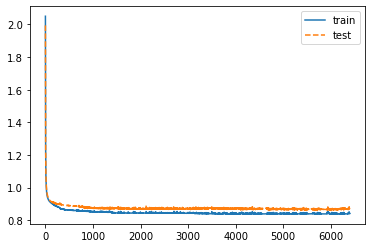

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.95898 | Loss: 0.884045184
| Epoch:   500 | Accuracy: 0.96973 | Loss: 0.872124851
| Epoch:  1000 | Accuracy: 0.96973 | Loss: 0.873294711
| Epoch:  1500 | Accuracy: 0.96973 | Loss: 0.873024583
| Epoch:  2000 | Accuracy: 0.96973 | Loss: 0.872725248
| Epoch:  2500 | Accuracy: 0.96973 | Loss: 0.871959865
| Epoch:  3000 | Accuracy: 0.96973 | Loss: 0.867560208
| Epoch:  3500 | Accuracy: 0.96875 | Loss: 0.868547022
| Epoch:  4000 | Accuracy: 0.96875 | Loss: 0.869286597
| Epoch:  4500 | Accuracy: 0.97168 | Loss: 0.868551731
| Epoch:  5000 | Accuracy: 0.97168 | Loss: 0.869788527
| Epoch:  5500 | Accuracy: 0.97070 | Loss: 0.871122539
Early stop.
Finished.


(3, 0.8621234893798828)

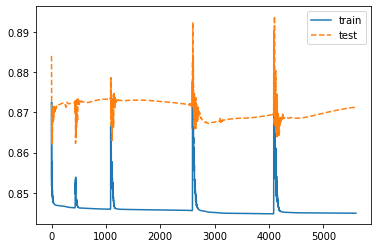

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.005)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.97363 | Loss: 0.861576557
| Epoch:   500 | Accuracy: 0.97070 | Loss: 0.873382449
| Epoch:  1000 | Accuracy: 0.96973 | Loss: 0.870597720
| Epoch:  1500 | Accuracy: 0.96973 | Loss: 0.871477962
| Epoch:  2000 | Accuracy: 0.97070 | Loss: 0.872746408
| Epoch:  2500 | Accuracy: 0.96973 | Loss: 0.873656094
| Epoch:  3000 | Accuracy: 0.96973 | Loss: 0.873876393
| Epoch:  3500 | Accuracy: 0.96875 | Loss: 0.874255240
| Epoch:  4000 | Accuracy: 0.96777 | Loss: 0.874562442
| Epoch:  4500 | Accuracy: 0.96777 | Loss: 0.875141919
| Epoch:  5000 | Accuracy: 0.96875 | Loss: 0.875253975
Early stop.
Finished.


(1, 0.8610169887542725)

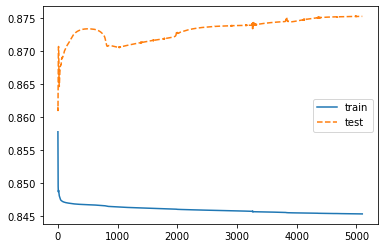

In [18]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [20]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.95703125


In [21]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=16, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=10, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [22]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [23]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.02)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.11426 | Loss: 1.395998478 |
| Epoch:   500 | Accuracy: 0.94141 | Loss: 0.159172162 |
| Epoch:  1000 | Accuracy: 0.94727 | Loss: 0.150771618 |
| Epoch:  1500 | Accuracy: 0.95312 | Loss: 0.148554891 |
| Epoch:  2000 | Accuracy: 0.95410 | Loss: 0.146984711 |
| Epoch:  2500 | Accuracy: 0.95312 | Loss: 0.113061816 |
| Epoch:  3000 | Accuracy: 0.95898 | Loss: 0.111249685 |
| Epoch:  3500 | Accuracy: 0.95898 | Loss: 0.108684704 |
| Epoch:  4000 | Accuracy: 0.96191 | Loss: 0.108796380 |
| Epoch:  4500 | Accuracy: 0.95996 | Loss: 0.108918853 |
| Epoch:  5000 | Accuracy: 0.95996 | Loss: 0.108867981 |
| Epoch:  5500 | Accuracy: 0.95898 | Loss: 0.110371292 |
| Epoch:  6000 | Accuracy: 0.95801 | Loss: 0.109735370 |
| Epoch:  6500 | Accuracy: 0.96094 | Loss: 0.110110469 |
| Epoch:  7000 | Accuracy: 0.95898 | Loss: 0.110163644 |
| Epoch:  7500 | Accuracy: 0.96094 | Loss: 0.109034345 |
Early stop.
Finished.


(5008, 0.10708852112293243)

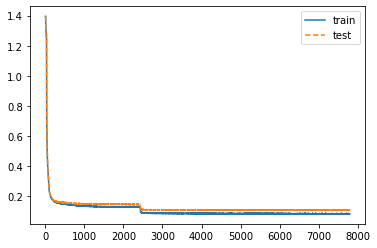

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [25]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.02)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.93359 | Loss: 0.154892206 |
| Epoch:   500 | Accuracy: 0.96289 | Loss: 0.109282389 |
| Epoch:  1000 | Accuracy: 0.96387 | Loss: 0.109539859 |
| Epoch:  1500 | Accuracy: 0.95996 | Loss: 0.110376410 |
| Epoch:  2000 | Accuracy: 0.96094 | Loss: 0.110094830 |
| Epoch:  2500 | Accuracy: 0.95996 | Loss: 0.109620109 |
| Epoch:  3000 | Accuracy: 0.96094 | Loss: 0.109165370 |
| Epoch:  3500 | Accuracy: 0.95996 | Loss: 0.110025376 |
| Epoch:  4000 | Accuracy: 0.95996 | Loss: 0.108800009 |
| Epoch:  4500 | Accuracy: 0.95996 | Loss: 0.109217137 |
| Epoch:  5000 | Accuracy: 0.95996 | Loss: 0.108561322 |
Early stop.
Finished.


(22, 0.10762736946344376)

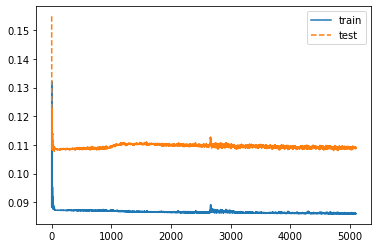

In [26]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [27]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.002)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.96094 | Loss: 0.107881136 |
| Epoch:   500 | Accuracy: 0.96191 | Loss: 0.108706683 |
| Epoch:  1000 | Accuracy: 0.96191 | Loss: 0.108864382 |
| Epoch:  1500 | Accuracy: 0.96191 | Loss: 0.108901083 |
| Epoch:  2000 | Accuracy: 0.96387 | Loss: 0.108871512 |
| Epoch:  2500 | Accuracy: 0.96387 | Loss: 0.108868010 |
| Epoch:  3000 | Accuracy: 0.96387 | Loss: 0.108846277 |
| Epoch:  3500 | Accuracy: 0.96387 | Loss: 0.108832419 |
| Epoch:  4000 | Accuracy: 0.96387 | Loss: 0.109010383 |
| Epoch:  4500 | Accuracy: 0.96289 | Loss: 0.109345853 |
| Epoch:  5000 | Accuracy: 0.96289 | Loss: 0.109738722 |
Early stop.
Finished.


(0, 0.10788113623857498)

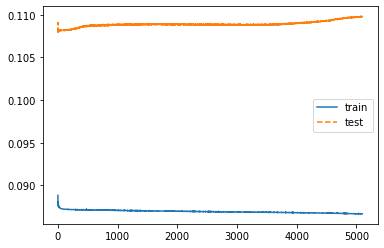

In [28]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [31]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [32]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [33]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.09082 | Loss: 1.399808288 |
| Epoch:     7 | Accuracy: 0.09082 | Loss: 1.394044518 |
| Epoch:    14 | Accuracy: 0.09815 | Loss: 1.380920887 |
| Epoch:    21 | Accuracy: 0.30002 | Loss: 1.059523106 |
| Epoch:    28 | Accuracy: 0.43850 | Loss: 0.769766152 |
| Epoch:    35 | Accuracy: 0.50813 | Loss: 0.666617870 |
| Epoch:    42 | Accuracy: 0.63090 | Loss: 0.569513917 |
| Epoch:    49 | Accuracy: 0.71530 | Loss: 0.494185477 |
| Epoch:    56 | Accuracy: 0.73333 | Loss: 0.469320834 |
| Epoch:    63 | Accuracy: 0.77345 | Loss: 0.410588950 |
| Epoch:    70 | Accuracy: 0.80729 | Loss: 0.367611676 |
| Epoch:    77 | Accuracy: 0.83694 | Loss: 0.312107742 |
| Epoch:    84 | Accuracy: 0.83243 | Loss: 0.325694025 |
| Epoch:    91 | Accuracy: 0.83696 | Loss: 0.312922895 |
| Epoch:    98 | Accuracy: 0.84341 | Loss: 0.300945461 |
| Epoch:   105 | Accuracy: 0.84401 | Loss: 0.292603254 |
| Epoch:   112 | Accuracy: 0.85418 | Loss: 0.276613027 |
| Epoch:   119 | Accuracy: 0.84

(147, 0.25241681933403015)

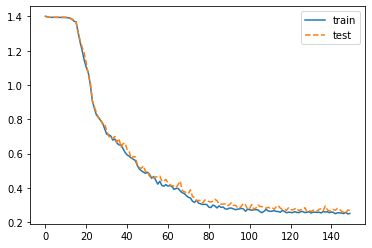

In [34]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [35]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.85438 | Loss: 0.268529624 |
| Epoch:    12 | Accuracy: 0.85690 | Loss: 0.265814394 |
| Epoch:    24 | Accuracy: 0.85774 | Loss: 0.267175049 |
| Epoch:    36 | Accuracy: 0.85897 | Loss: 0.267878950 |
| Epoch:    48 | Accuracy: 0.85776 | Loss: 0.264271945 |
| Epoch:    60 | Accuracy: 0.86226 | Loss: 0.255209178 |
| Epoch:    72 | Accuracy: 0.85782 | Loss: 0.265723109 |
| Epoch:    84 | Accuracy: 0.85348 | Loss: 0.273222417 |
| Epoch:    96 | Accuracy: 0.85953 | Loss: 0.262868077 |
| Epoch:   108 | Accuracy: 0.85521 | Loss: 0.269981444 |
| Epoch:   120 | Accuracy: 0.85142 | Loss: 0.277560920 |
| Epoch:   132 | Accuracy: 0.86045 | Loss: 0.263728648 |
| Epoch:   144 | Accuracy: 0.85834 | Loss: 0.266767800 |
| Epoch:   156 | Accuracy: 0.86081 | Loss: 0.260899276 |
| Epoch:   168 | Accuracy: 0.85960 | Loss: 0.258337766 |
| Epoch:   180 | Accuracy: 0.85831 | Loss: 0.256663233 |
| Epoch:   192 | Accuracy: 0.86260 | Loss: 0.254146487 |
| Epoch:   204 | Accuracy: 0.86

(148, 0.24681386351585388)

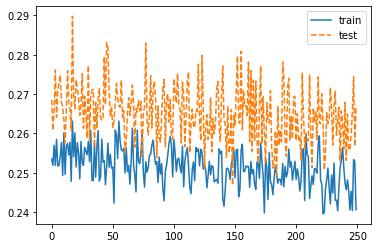

In [36]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [37]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.85530 | Loss: 0.268144518 |
| Epoch:    12 | Accuracy: 0.85827 | Loss: 0.263264298 |
| Epoch:    24 | Accuracy: 0.85925 | Loss: 0.263776928 |
| Epoch:    36 | Accuracy: 0.86176 | Loss: 0.259476870 |
| Epoch:    48 | Accuracy: 0.86092 | Loss: 0.259006351 |
| Epoch:    60 | Accuracy: 0.85743 | Loss: 0.266446948 |
| Epoch:    72 | Accuracy: 0.85971 | Loss: 0.260527253 |
| Epoch:    84 | Accuracy: 0.86058 | Loss: 0.255521506 |
| Epoch:    96 | Accuracy: 0.86498 | Loss: 0.251751870 |
| Epoch:   108 | Accuracy: 0.85749 | Loss: 0.266647279 |
| Epoch:   120 | Accuracy: 0.85792 | Loss: 0.260258019 |
| Epoch:   132 | Accuracy: 0.85730 | Loss: 0.268084675 |
| Epoch:   144 | Accuracy: 0.85839 | Loss: 0.262130529 |
| Epoch:   156 | Accuracy: 0.85922 | Loss: 0.257790148 |
| Epoch:   168 | Accuracy: 0.86314 | Loss: 0.257271230 |
| Epoch:   180 | Accuracy: 0.85831 | Loss: 0.266858935 |
| Epoch:   192 | Accuracy: 0.86050 | Loss: 0.260673374 |
| Epoch:   204 | Accuracy: 0.86

(136, 0.248687744140625)

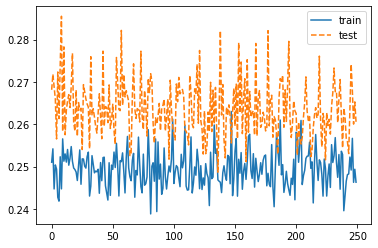

In [38]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [39]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)